In [1]:
from RzLinear import RzLinearFunction
import torch
from RzLinear import RzLinear 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import rz_linear
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [2]:
DEV=0
TILED = True
input_dim = 40000
output_dim = 500
weight_size = 1000000
chunk_size = 2
r = np.random.RandomState(1024)
x = r.randint(0, 2038074743, (50,))
x = x + 1*(x%2==0);
random_numbers = torch.from_numpy(np.concatenate([np.array([2038074743]), x])).long().cuda(DEV) # set of 50 random numbers to use

In [3]:
idx =rz_linear.get_idx(random_numbers, input_dim, output_dim, chunk_size, weight_size, TILED)
torch.cuda.synchronize()

In [4]:
idx

tensor([[490689, 490690, 490691,  ...,  94192,  94193,  94194],
        [490705, 490706, 490707,  ...,  94208,  94209,  94210],
        [490721, 490722, 490723,  ...,  94224,  94225,  94226],
        ...,
        [974406, 974407, 974408,  ..., 577909, 577910, 577911],
        [974422, 974423, 974424,  ..., 577925, 577926, 577927],
        [974438, 974439, 974440,  ..., 577941, 577942, 577943]],
       device='cuda:0')

(array([1997294., 1998764., 1999517., 2001469., 1999675., 1999636.,
        2002330., 2002243., 2000790., 1998282.]),
 array([1.000000e+00, 1.000001e+05, 1.999992e+05, 2.999983e+05,
        3.999974e+05, 4.999965e+05, 5.999956e+05, 6.999947e+05,
        7.999938e+05, 8.999929e+05, 9.999920e+05]),
 <a list of 10 Patch objects>)

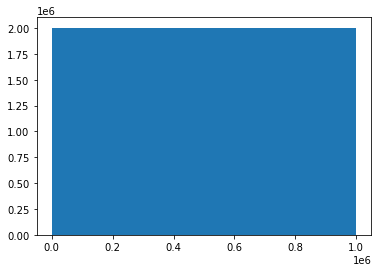

In [5]:
plt.hist(np.array(idx.reshape(-1).cpu().detach()))

In [7]:
hashed_weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1/np.sqrt(output_dim), 1/np.sqrt(output_dim), size=weight_size).astype(np.float32))).to("cuda:0")
#hashed_weight = nn.Parameter(torch.rand((weight_size))).to("cuda:0")

In [8]:
weight = nn.Parameter(torch.clone(hashed_weight[idx].detach())).cuda(0)

In [9]:
def forward_actual(inp, wt):
    return torch.mm(inp, wt)

def forward_rz(inp, hwt):
    return RzLinearFunction.forwardproxy(hwt, inp ,random_numbers, input_dim, output_dim, chunk_size, TILED)

input_v = nn.Parameter(torch.rand((5,input_dim)), requires_grad=True).cuda(0)
A = forward_actual(input_v, weight)
B = forward_rz(input_v, hashed_weight)
torch.max(torch.abs(A - B))

tensor(6.4850e-05, device='cuda:0', grad_fn=<MaxBackward1>)

In [10]:
weight, hashed_weight

(Parameter containing:
 tensor([[ 0.0060,  0.0394,  0.0427,  ...,  0.0140,  0.0431, -0.0169],
         [-0.0177,  0.0372, -0.0341,  ...,  0.0350,  0.0351,  0.0257],
         [-0.0308,  0.0392,  0.0227,  ...,  0.0257,  0.0251, -0.0170],
         ...,
         [-0.0358,  0.0023, -0.0368,  ..., -0.0355, -0.0335,  0.0248],
         [ 0.0156, -0.0169, -0.0120,  ...,  0.0179, -0.0104,  0.0419],
         [ 0.0016,  0.0225,  0.0189,  ...,  0.0007,  0.0163, -0.0350]],
        device='cuda:0', requires_grad=True),
 tensor([-0.0402,  0.0026,  0.0072,  ...,  0.0050,  0.0002, -0.0431],
        device='cuda:0', grad_fn=<CopyBackwards>))

In [11]:
A,B

(tensor([[-1.7615,  2.8697,  5.8295,  ..., -2.3295,  4.4663,  6.9032],
         [-2.7469,  1.3401,  4.3010,  ..., -5.3618,  4.9123,  8.2675],
         [-2.7312,  2.4597,  5.5347,  ..., -5.6957,  1.9609,  6.3627],
         [-3.4171,  0.1643,  5.2013,  ..., -8.2271,  4.5357,  7.8807],
         [-2.0603,  2.8020,  6.8687,  ..., -4.2195,  0.5374,  7.4021]],
        device='cuda:0', grad_fn=<MmBackward>),
 tensor([[-1.7616,  2.8697,  5.8295,  ..., -2.3295,  4.4663,  6.9032],
         [-2.7469,  1.3401,  4.3010,  ..., -5.3618,  4.9124,  8.2676],
         [-2.7312,  2.4597,  5.5346,  ..., -5.6957,  1.9608,  6.3627],
         [-3.4171,  0.1643,  5.2013,  ..., -8.2271,  4.5357,  7.8807],
         [-2.0603,  2.8020,  6.8687,  ..., -4.2195,  0.5374,  7.4021]],
        device='cuda:0'))

In [12]:
def forward_actual(inp, wt):
    X = torch.matmul(inp, wt)
    return torch.sum(X)

def forward_rz(inp, hwt):
    X= RzLinearFunction.forwardproxy(hwt, inp ,random_numbers, input_dim, output_dim, chunk_size, TILED)
    return torch.sum(X)

def backward_actual(inp, wt):
    A = forward_actual(inp, wt)
    A.backward()
    return wt.grad, inp.grad

def backward_rz(inp, hwt):
    B = forward_rz(inp, hwt)
    grad = torch.ones((inp.shape[0], output_dim)).cuda(0)
    in_grad, wt_grad = RzLinearFunction.backwardproxy(grad, hwt, inp, random_numbers, input_dim, output_dim, chunk_size, TILED)
    return in_grad, wt_grad

In [13]:
input_v = nn.Parameter(torch.rand((5,input_dim)), requires_grad=True).cuda(0)
input_v.retain_grad()
in_grad, wt_grad = backward_rz(input_v, hashed_weight)
wt_grad_2, in_grad_2 = backward_actual(input_v, weight)

In [14]:
wt_grad_actual_p = torch.zeros_like(hashed_weight).cuda(0)
wt_grad_actual_p.scatter_add_(0, idx.reshape(-1), wt_grad_2.reshape(-1))
print(torch.max(torch.abs(wt_grad_actual_p - wt_grad)))

tensor(4.5776e-05, device='cuda:0')


In [15]:
print(torch.max(torch.abs(in_grad_2 - in_grad)))

tensor(2.1458e-06, device='cuda:0')


In [16]:
wt_grad_actual_p

tensor([0.0000, 2.8988, 2.8988,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [17]:
wt_grad

tensor([0.0000, 2.8988, 2.8988,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [18]:
wt_grad[wt_grad!=0]

tensor([2.8988, 2.8988, 2.8988,  ..., 2.3053, 2.3053, 2.3053], device='cuda:0')

In [19]:
in_grad_2,in_grad

(tensor([[-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151]],
        device='cuda:0'),
 tensor([[-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151],
         [-0.5413,  0.8012, -0.5487,  ..., -0.4879,  1.0071, -0.1151]],
        device='cuda:0'))